# Task 2 - Model Developemnt

In [2]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, 
    f1_score, roc_auc_score, roc_curve, confusion_matrix
)
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

Training and tuning Logistic Regression...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters for Logistic Regression: {}
Training and tuning Random Forest...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters for Random Forest: {}
Training and tuning Decision Tree...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters for Decision Tree: {}
Training and tuning Gradient Boosting...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters for Gradient Boosting: {}
Training and tuning AdaBoost...
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/anaconda3/envs/red_cloud_technology/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/red_cloud_technology/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/red_cloud_technology/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/red_cloud_technology/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated a

Best parameters for AdaBoost: {}
Training and tuning XGBoost...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters for XGBoost: {}
Training and tuning SVM...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters for SVM: {}
Training and tuning KNN...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters for KNN: {}
Training and tuning Voting Ensemble...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters for Voting Ensemble: {}
                 Model  Accuracy  Precision    Recall  F1-Score   ROC-AUC
0  Logistic Regression  0.796507   0.445521  0.825112  0.578616  0.880535
1        Random Forest  0.916477   0.748899  0.762332  0.755556  0.940634
2        Decision Tree  0.845862   0.529412  0.807175  0.639432  0.880358
3    Gradient Boosting  0.926348   0.824742  0.717489  0.767386  0.940036
4             AdaBoost  0.859529   0.806452  0.224215  0.350877  0.876149
5              XGBoost  0.924829   

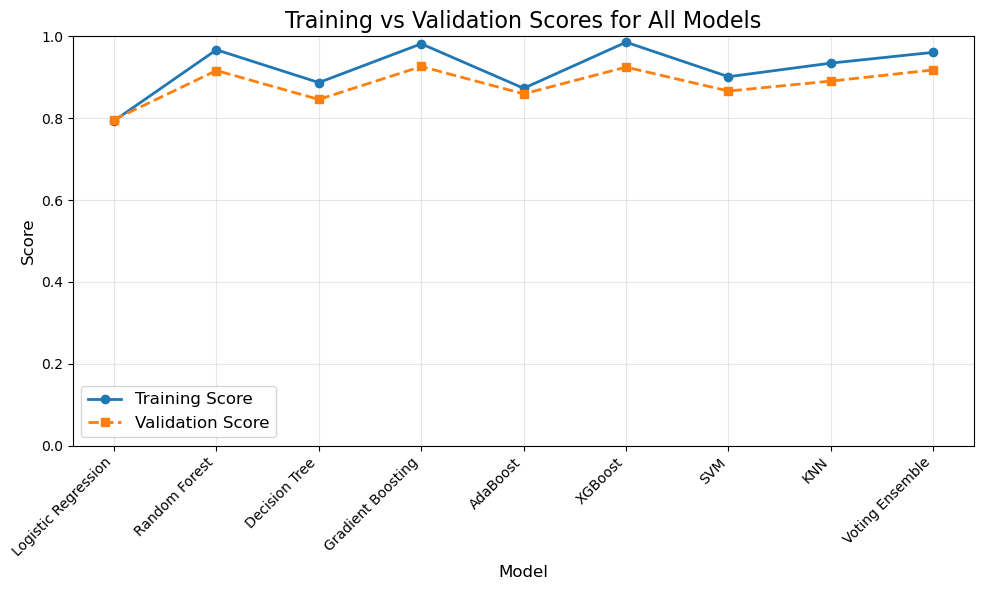

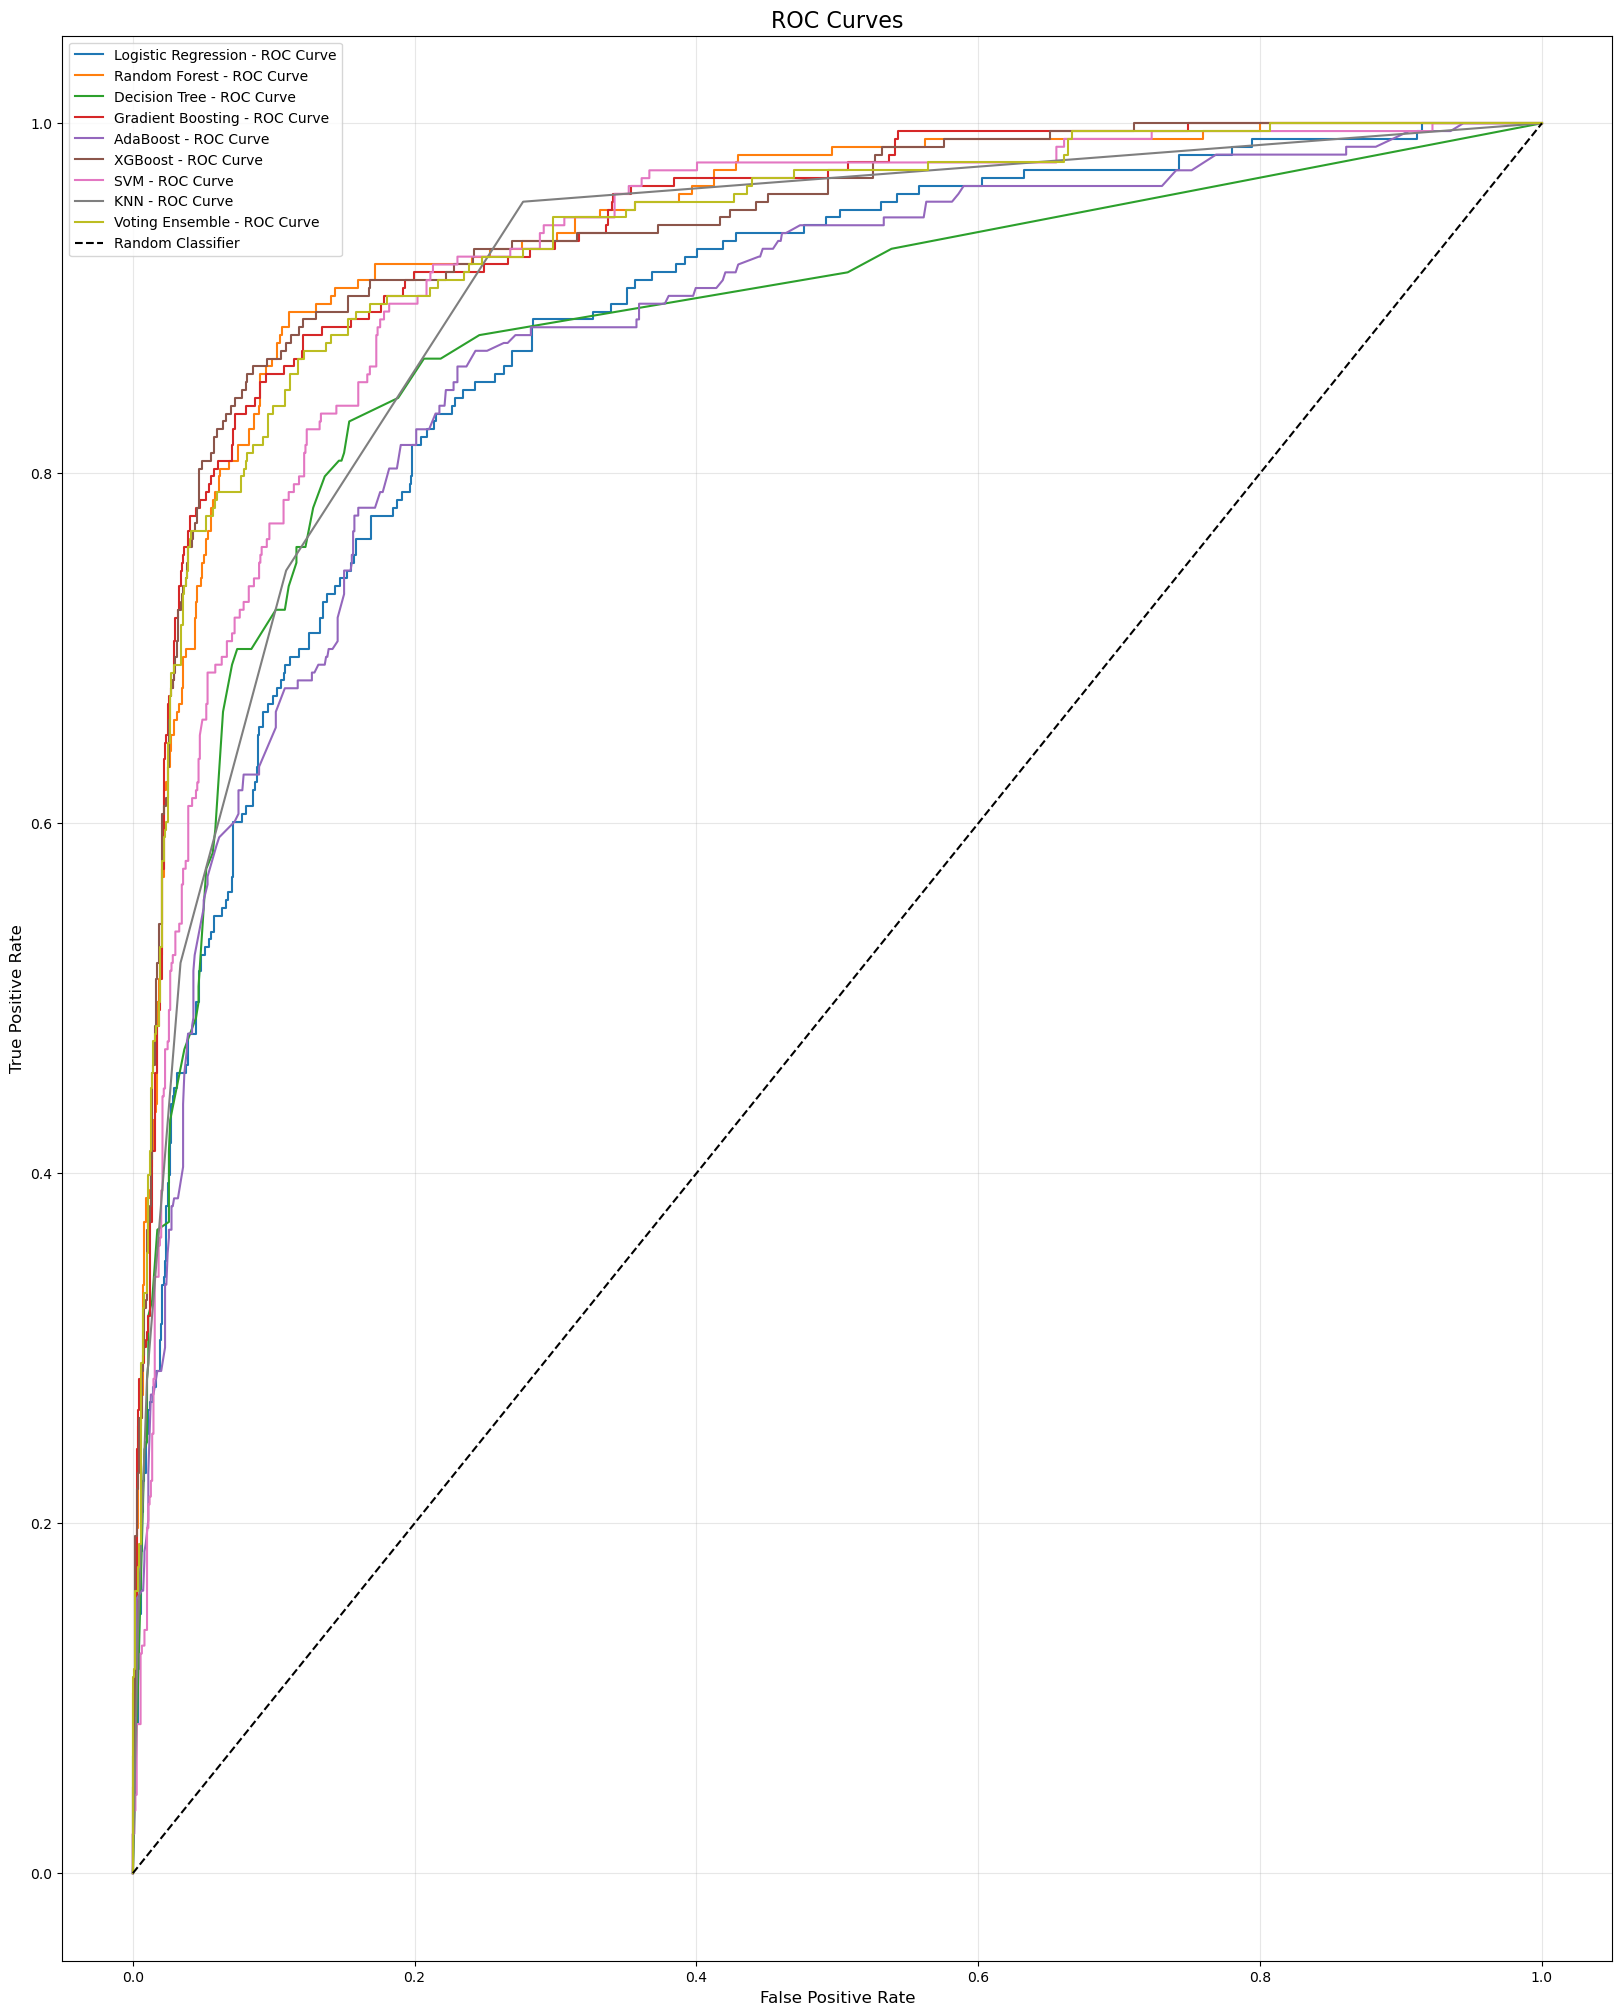

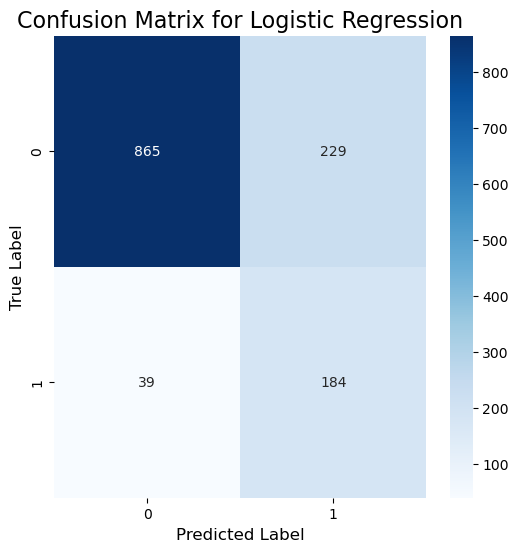

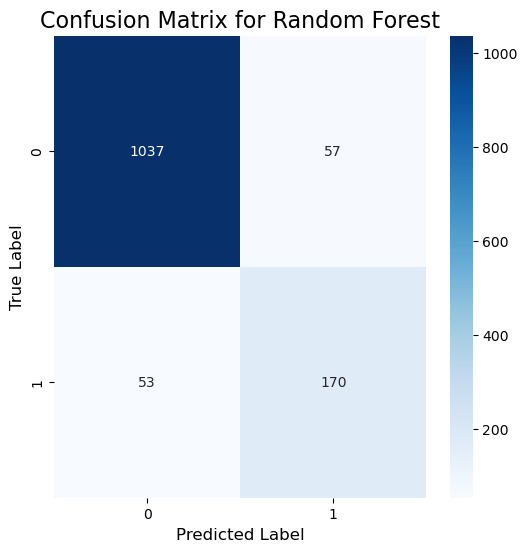

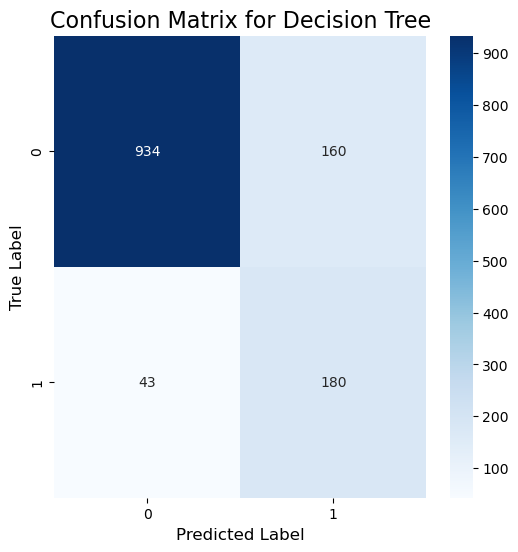

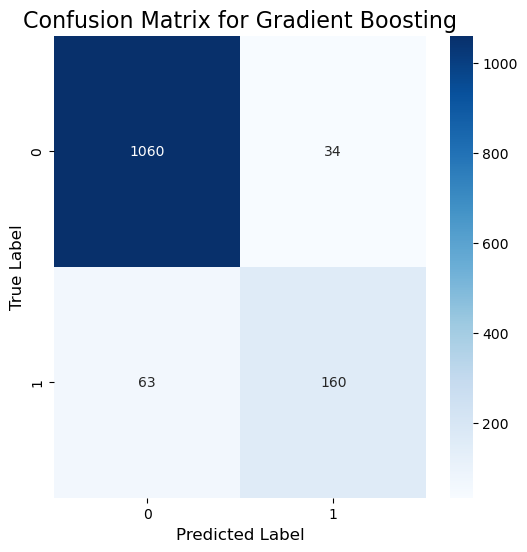

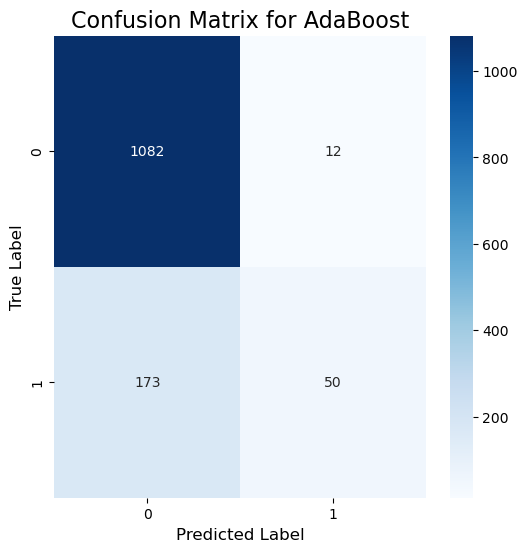

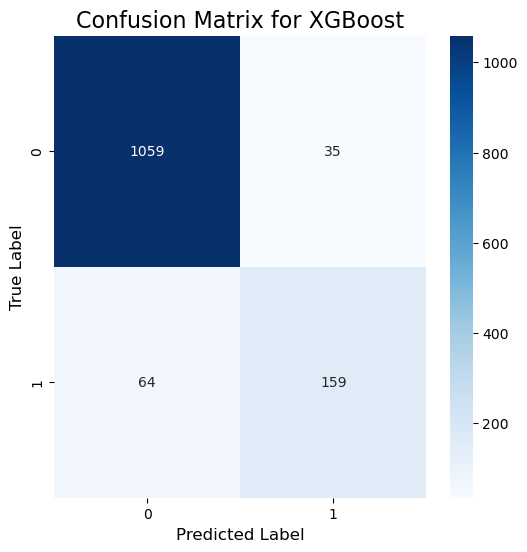

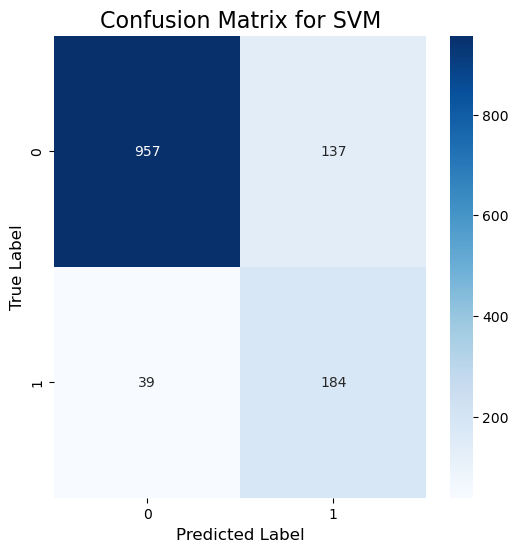

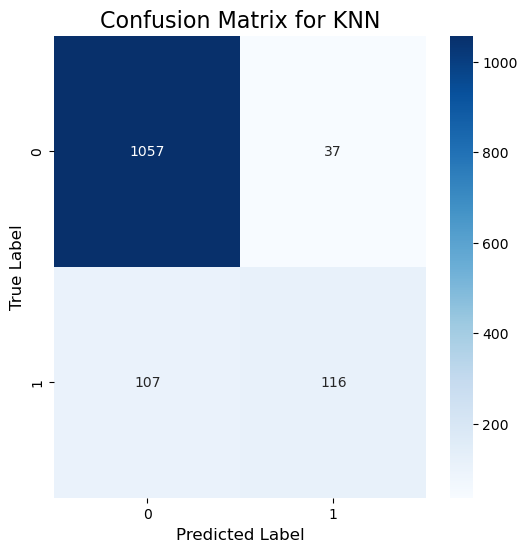

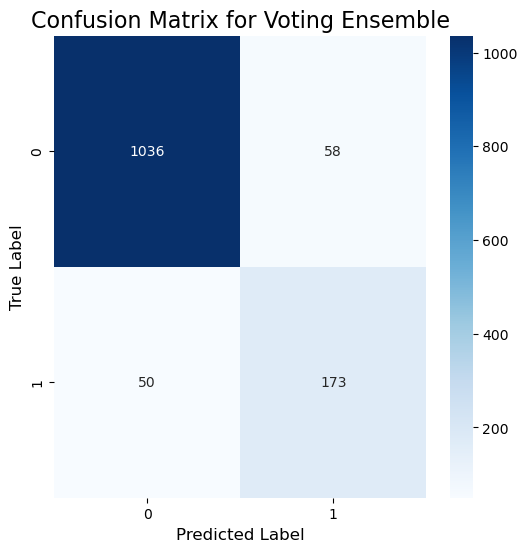

In [ ]:

# Step 1: Data Loading
def load_data(file_path):
    data = pd.read_csv(file_path)
    return data

# Step 2: Data Preprocessing
def preprocess_data(data, target_col, drop_cols=None):
    available_columns = data.columns
    if drop_cols:
        drop_cols = [col for col in drop_cols if col in available_columns]
        data = data.drop(columns=drop_cols)
    X = data.drop(columns=[target_col])
    y = data[target_col]
    X = X[y.notna()]
    y = y[y.notna()]
    return X, y

# Step 3: Resampling for Class Imbalance
def resample_data(X_train, y_train, preprocessor, numeric_features, categorical_features):
    X_train_encoded = preprocessor.fit_transform(X_train)
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_train_encoded, y_train)
    column_names = (
        numeric_features + 
        list(preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features))
    )
    X_resampled_df = pd.DataFrame(X_resampled, columns=column_names)
    return X_resampled_df, y_resampled

# Step 4: Feature Engineering
def build_preprocessor(X):
    numeric_features = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
    categorical_features = X.select_dtypes(include=['object']).columns.tolist()
    
    ordinal_features = ['SatisfactionScore']  # Use numeric SatisfactionScore for ordinal encoding
    if 'SatisfactionScoreText' in categorical_features:
        categorical_features.remove('SatisfactionScoreText')  # Remove SatisfactionScoreText from general categorical list
        categorical_features = ['SatisfactionScoreText'] + categorical_features  # Add it first for one-hot encoding

    scaler_preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ]
    )

    tree_preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ],
        remainder='passthrough'
    )

    ordinal_preprocessor = ColumnTransformer(
        transformers=[
            ('ordinal', OrdinalEncoder(), ordinal_features),
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ]
    )

    return scaler_preprocessor, tree_preprocessor, ordinal_preprocessor, numeric_features, categorical_features

# Step 5: Model Training with Hyperparameter Tuning
def train_models_with_tuning(X_train, y_train, models_with_preprocessors, param_grids):
    """
    Train models with hyperparameter tuning using GridSearchCV.
    """
    tuned_models = {}

    for name, (model, preprocessor) in models_with_preprocessors.items():
        print(f"Training and tuning {name}...")
        
        # Create a pipeline with the preprocessor and classifier
        pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])
        
        # Adjust parameter grid for pipeline structure
        if name in param_grids:
            grid = {f'classifier__{key}': value for key, value in param_grids[name].items()}
        else:
            grid = {}

        # Apply GridSearchCV for hyperparameter tuning
        search = GridSearchCV(
            pipeline,
            param_grid=grid,
            scoring='roc_auc',
            cv=5,
            n_jobs=-1,
            verbose=1
        )
        
        try:
            # Fit GridSearchCV
            search.fit(X_train, y_train)
            tuned_models[name] = search.best_estimator_
            print(f"Best parameters for {name}: {search.best_params_}")
        except ValueError as e:
            print(f"Skipping {name} due to error: {e}")
    
    return tuned_models



# Step 6: Model Evaluation
def evaluate_models(trained_models, X_test, y_test):
    results = []
    for name, pipeline in trained_models.items():
        # Use the full pipeline for predictions
        y_pred = pipeline.predict(X_test)
        y_prob = pipeline.predict_proba(X_test)[:, 1]

        # Collect metrics
        results.append({
            "Model": name,
            "Accuracy": accuracy_score(y_test, y_pred),
            "Precision": precision_score(y_test, y_pred, zero_division=0),
            "Recall": recall_score(y_test, y_pred),
            "F1-Score": f1_score(y_test, y_pred),
            "ROC-AUC": roc_auc_score(y_test, y_prob)
        })
    return pd.DataFrame(results)



# Step 7: Confusion Matrix Plotting
def plot_confusion_matrices(trained_models, X_test, y_test):
    for name, pipeline in trained_models.items():
        # Use the pipeline for predictions
        y_pred = pipeline.predict(X_test)
        
        # Compute the confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        
        # Plot the confusion matrix
        plt.figure(figsize=(6, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
        plt.title(f"Confusion Matrix for {name}", fontsize=16)
        plt.xlabel("Predicted Label", fontsize=12)
        plt.ylabel("True Label", fontsize=12)
        plt.show()


# Step 8: Training vs Validation Scores Plotting
def plot_training_validation_scores(trained_models, X_train, y_train, X_test, y_test):
    plt.figure(figsize=(10, 6))
    model_names = []
    training_scores = []
    validation_scores = []

    for name, pipeline in trained_models.items():
        train_score = pipeline.score(X_train, y_train)
        test_score = pipeline.score(X_test, y_test)
        model_names.append(name)
        training_scores.append(train_score)
        validation_scores.append(test_score)
    
    plt.plot(model_names, training_scores, marker='o', label='Training Score', linestyle='-', linewidth=2)
    plt.plot(model_names, validation_scores, marker='s', label='Validation Score', linestyle='--', linewidth=2)
    plt.title("Training vs Validation Scores for All Models", fontsize=16)
    plt.xlabel("Model", fontsize=12)
    plt.ylabel("Score", fontsize=12)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.ylim(0, 1)
    plt.legend(fontsize=12)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# Step 9: ROC Curve Plotting
def plot_roc_curves(trained_models, X_test, y_test):
    plt.figure(figsize=(20, 25))
    for name, pipeline in trained_models.items():
        y_prob = pipeline.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        plt.plot(fpr, tpr, label=f'{name} - ROC Curve')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
    plt.title('ROC Curves', fontsize=16)
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(alpha=0.3)
    plt.show()

# Main Execution
if __name__ == "__main__":
    file_path = "/Users/vinoth/Library/Mobile Documents/com~apple~CloudDocs/Job Assignment/Red Cloud Technology/technical_challenge/final_challenge_dataset.csv"
    data = load_data(file_path)

    target_col = "Churn"
    drop_cols = ["CustomerID", "OrderAmountHikeFromlastYear"]
    X, y = preprocess_data(data, target_col, drop_cols)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    scaler_preprocessor, tree_preprocessor, ordinal_preprocessor, numeric_features, categorical_features = build_preprocessor(X_train)

    models_with_preprocessors = {
    "Logistic Regression": (
        LogisticRegression(max_iter=500, class_weight='balanced', C=1.0),  # Default regularization
        scaler_preprocessor
    ),
    "Random Forest": (
        RandomForestClassifier(
            random_state=42,
            class_weight='balanced',
            max_depth=10,  # Limit depth
            min_samples_split=5,  # Minimum samples required to split a node
            min_samples_leaf=2  # Minimum samples in a leaf node
        ),
        tree_preprocessor
    ),
    "Decision Tree": (
        DecisionTreeClassifier(
            random_state=42,
            class_weight='balanced',
            max_depth=8,  # Limit depth
            min_samples_split=10,  # Minimum samples required to split
            min_samples_leaf=4  # Minimum samples in a leaf node
        ),
        tree_preprocessor
    ),
    "Gradient Boosting": (
        GradientBoostingClassifier(
            random_state=42,
            max_depth=5,  # Restrict tree depth
            learning_rate=0.1,  # Step size
            n_estimators=100  # Number of boosting stages
        ),
        tree_preprocessor
    ),
    "AdaBoost": (
        AdaBoostClassifier(
            random_state=42,
            n_estimators=50,  # Number of boosting stages
            learning_rate=0.1  # Step size
        ),
        tree_preprocessor
    ),
    "XGBoost": (
        XGBClassifier(
            eval_metric='logloss',
            random_state=42,
            max_depth=6,  # Restrict tree depth
            learning_rate=0.1,  # Step size
            reg_lambda=1.0,  # L2 regularization
            reg_alpha=0.0,  # L1 regularization
            n_estimators=100  # Number of boosting stages
        ),
        tree_preprocessor
    ),
    "SVM": (
        SVC(
            probability=True,
            random_state=42,
            class_weight='balanced',
            C=1.0  # Regularization parameter for SVM
        ),
        scaler_preprocessor
    ),
    "KNN": (
        KNeighborsClassifier(
            n_neighbors=5,  # Number of neighbors
            weights='uniform'  # Uniform weighting
        ),
        scaler_preprocessor
    ),
    "Voting Ensemble": (
        VotingClassifier(
            estimators=[
                ('lr', LogisticRegression(max_iter=500, class_weight='balanced')),
                ('rf', RandomForestClassifier(
                    random_state=42,
                    class_weight='balanced',
                    max_depth=10,
                    min_samples_split=5,
                    min_samples_leaf=2
                )),
                ('gb', GradientBoostingClassifier(
                    random_state=42,
                    max_depth=5,
                    learning_rate=0.1
                ))
            ],
            voting='soft'
        ),
        scaler_preprocessor
    )
}
    
    # Define parameter grids for hyperparameter tuning
    param_grids = {
        "Logistic Regression": {
            "classifier__class_weight": [0.01, 0.1, 1.0, 10.0],  # Regularization strength
            "classifier__max_iter": [100, 200, 500]   # Maximum iterations
        },
        "Random Forest": {
            "classifier__n_estimators": [50, 100, 200],  # Number of trees
            "classifier__max_depth": [None, 10, 20],     # Maximum tree depth
            "classifier__min_samples_split": [2, 5, 10], # Min samples required to split
            "classifier__min_samples_leaf": [1, 2, 4]    # Min samples in a leaf
        },
        "Decision Tree": {
            "classifier__max_depth": [None, 5, 10, 15],   # Maximum tree depth
            "classifier__min_samples_split": [2, 5, 10],  # Min samples required to split
            "classifier__min_samples_leaf": [1, 2, 4]     # Min samples in a leaf
        },
        "Gradient Boosting": {
            "classifier__learning_rate": [0.01, 0.1, 0.2],  # Step size shrinkage
            "classifier__n_estimators": [50, 100, 200],     # Number of boosting stages
            "classifier__max_depth": [3, 5, 7]              # Maximum tree depth
        },
        "AdaBoost": {
            "classifier__n_estimators": [50, 100, 200],     # Number of boosting stages
            "classifier__learning_rate": [0.01, 0.1, 0.2],  # Learning rate
            "classifier__algorithm": ["SAMME", "SAMME.R"]   # Boosting algorithm
        },
        "XGBoost": {
            "classifier__max_depth": [3, 5, 7],             # Maximum tree depth
            "classifier__learning_rate": [0.01, 0.1, 0.2],  # Step size shrinkage
            "classifier__n_estimators": [50, 100, 200],     # Number of boosting stages
            "classifier__reg_lambda": [0.1, 1.0, 10.0],     # L2 regularization
            "classifier__reg_alpha": [0, 0.1, 1.0]          # L1 regularization
        },
        "SVM": {
            "classifier__C": [0.01, 0.1, 1.0, 10.0],        # Regularization strength
            "classifier__kernel": ["linear", "rbf"],        # Kernel type
            "classifier__gamma": ["scale", "auto"]          # Kernel coefficient
        },
        "KNN": {
            "classifier__n_neighbors": [3, 5, 7],           # Number of neighbors
            "classifier__weights": ["uniform", "distance"], # Weight function
            "classifier__metric": ["minkowski", "euclidean", "manhattan"] # Distance metric
        },
        "Voting Ensemble": {
            # For Voting Ensemble, we cannot tune the base models in the grid search.
            # However, we can tune weights for individual estimators in the ensemble.
            "classifier__weights": [[1, 1, 1], [2, 1, 1], [1, 2, 1]],  # Example weight combinations
            "classifier__voting": ["hard", "soft"]  # Voting type
        }
    }

    # Param Grid(hyperparameter tuning) is for future enhancment. Not implemented in this submission. 

    # Train models
    trained_models = train_models_with_tuning(X_train, y_train, models_with_preprocessors, param_grids={})

    # Evaluate models using the updated function
    performance_df = evaluate_models(trained_models, X_test, y_test)
    print(performance_df)
    
    # Plot Training vs Validation Scores
    plot_training_validation_scores(
        trained_models, 
        X_train, 
        y_train, 
        X_test,  # Pass raw X_test here
        y_test
    )

    # Plot ROC Curves
    plot_roc_curves(trained_models, X_test, y_test)

    # Plot Confusion Matrices
    plot_confusion_matrices(trained_models, X_test, y_test)


